# Подготовка данных

In [20]:
from sklearn import ensemble , cross_validation, metrics, preprocessing,tree,neural_network,manifold,linear_model,neighbors,model_selection, ensemble
#самая распространенная библиотека по машин лернингу
import numpy as np
#линейная алгебра
import pandas as pd
#работа с датасетами
import xgboost as xgb
#градиентный бустинг
from matplotlib import pyplot as plt
import matplotlib.cm as cm # импортируем цветовые схемы, чтобы рисовать графики.
%matplotlib inline
import seaborn as sns
#графики, и красивые графики

In [4]:
bank=pd.read_csv("/home/stas/data/bank.csv",sep=";")
bank.columns
#имортируем датасет

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

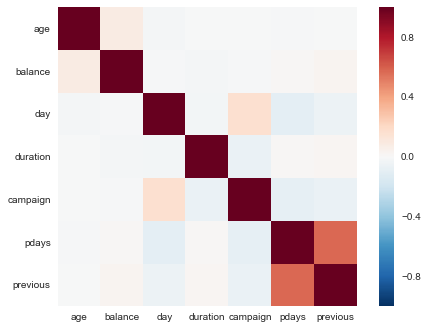

In [5]:
sns.heatmap(bank.corr(), square=True)

In [32]:
bank_vords=bank.dtypes[test.dtypes == "object"].index#выделить не числовые переменные
bank_numeric=bank.dtypes[test.dtypes != "object"].index#выделить числовые переменные
#делим на вещественный(численные) и строчные признаки

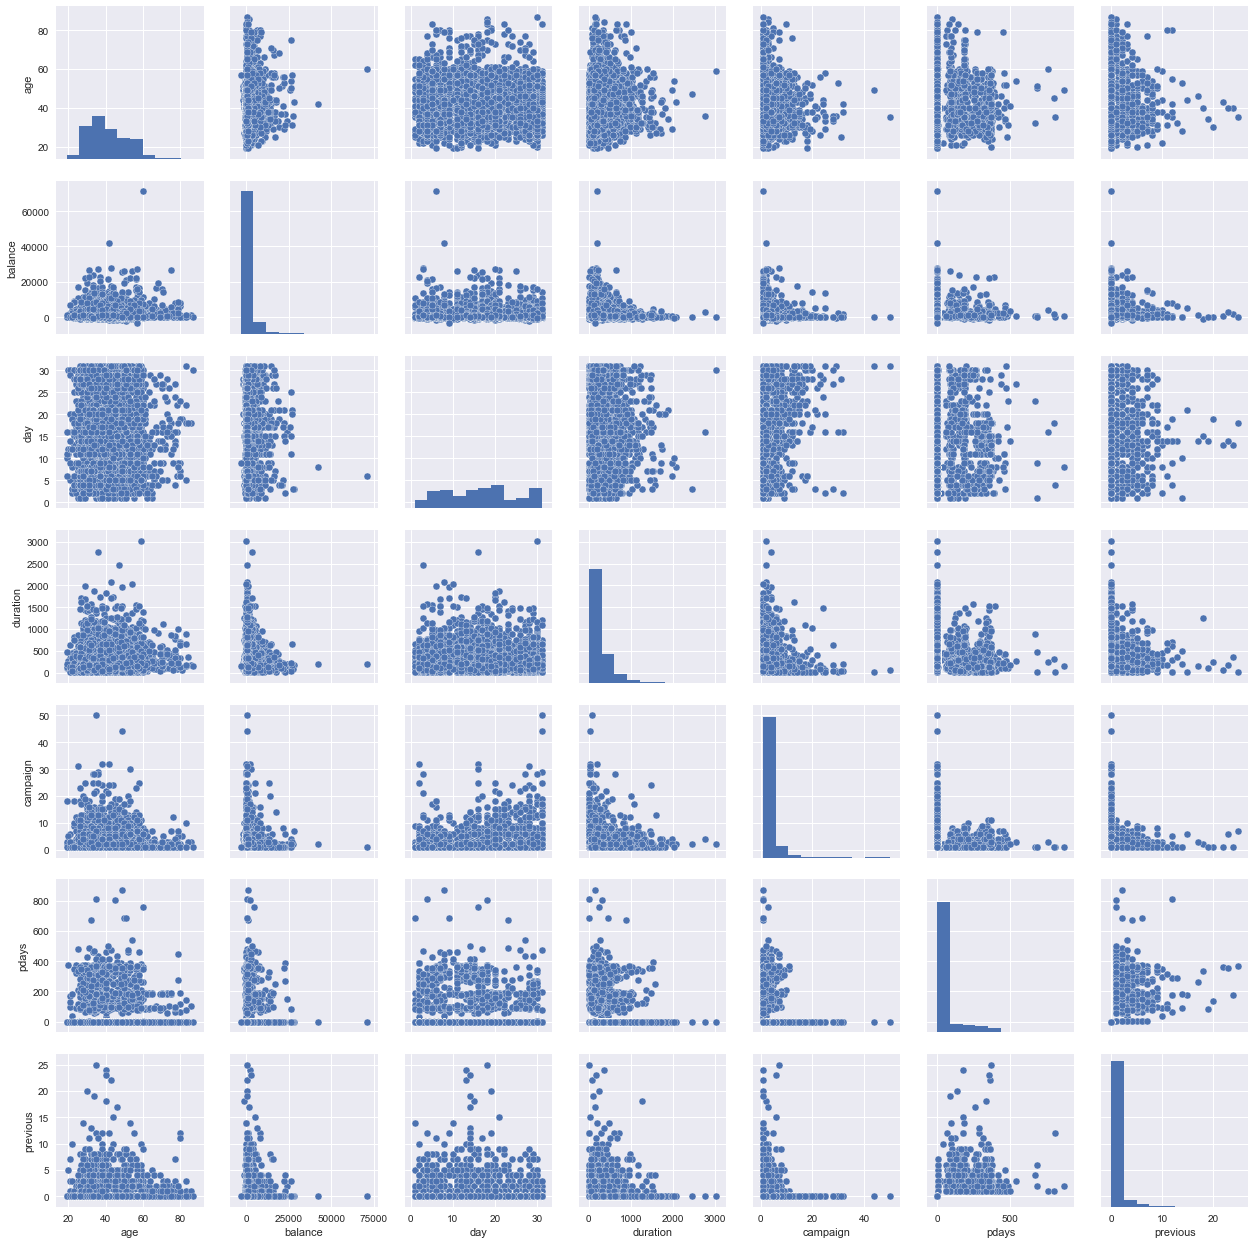

In [18]:
sns.pairplot(bank_numeric)

In [33]:
le = preprocessing.LabelEncoder()

X=[]

for i in range(0,10):
    X.append(le.fit_transform(bank_vords.iloc[:,[i]]))
    #преобразовываем строковые к численным и к нампаевскому массиву

X1=np.ones((7,4521))
for i in range(0,7):
    X1[i]=np.array(bank_numeric.iloc[:,[i]]).T
    #тут просто к нампаевскому

/home/stas/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [34]:
y=np.array(X[9])
X_num=np.array(X[:9])
X_col=X1
new_X=np.hstack((X_num.T,X_col.T))
#склеиваем признаки на которых будем обучаться, и выделяем переменную с ответами

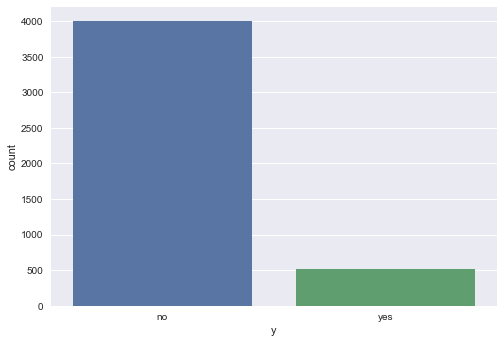

In [10]:
sns.countplot(bank.y)

# Начинам обучение
проверять качество будем кросс-валидацией с разбитием на 10 фолдов, дабы уменьшить дисперсию

In [29]:
%%time
ts=manifold.TSNE(metric="cosine")
tsne_representation=ts.fit_transform(new_X)

CPU times: user 1min 9s, sys: 5.08 s, total: 1min 14s
Wall time: 1min 14s


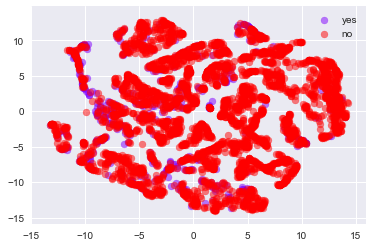

In [30]:
colors = cm.rainbow(np.linspace(0, 1, len(set(X[9]))))
for y, c in zip(set(bank.y), colors):
    plt.scatter(tsne_representation[bank.y.values==y, 0], 
                tsne_representation[bank.y.values==y, 1], c=c, alpha=0.5, label=str(y))
plt.legend()

CPU times: user 20min 39s, sys: 4min 59s, total: 25min 38s
Wall time: 29min 47s


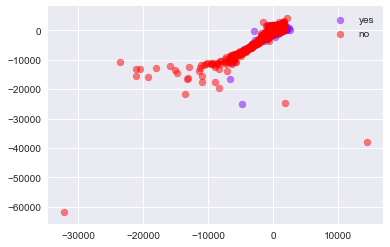

In [28]:
%%time
mda=manifold.MDS()
mda_representation=mda.fit_transform(new_X)

colors = cm.rainbow(np.linspace(0, 1, len(set(X[9]))))
for y, c in zip(set(bank.y), colors):
    plt.scatter(mda_representation[bank.y.values==y, 0], 
                mda_representation[bank.y.values==y, 1], c=c, alpha=0.5, label=str(y))
plt.legend()
#мда, и новой инфы не дало, и ниодну катку в сапера не выграл, ждя пока оно досчитается

In [35]:
estimator = xgb.XGBClassifier(learning_rate=0.01, max_depth=1000, n_estimators=1000, min_child_weight=3)
cross_validation.cross_val_score(estimator, new_X, y,scoring = 'roc_auc', cv = 10).mean()
#Самый универсальный градиентный бустинг, с него и начнем

0.90709316037735854

In [36]:
tree_clf=ensemble.RandomForestClassifier(n_estimators=500,max_depth=4000)
cross_validation.cross_val_score(tree_clf, new_X, y,scoring = 'roc_auc', cv = 10).mean()
#tree_clf.fit(new_X, y)
#Далее мой любимый случайный лес, в 500 деревьев и очень глубокими ветвями

0.91132179789550083

In [37]:
%%time
q=[]
neur_count=[4,7,10,13]
for i in neur_count:
    neur=neural_network.MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(16,i,2))
    q.append([cross_validation.cross_val_score(neur, new_X, y,scoring = 'roc_auc', cv = 10).mean(),i])
    #далее построим многослоиную классифицирующую) перцептронную нейронную сеть первый слой 16,
    #равный колл-ву признаков,2 слой- эксперементально выведем оптимальное колл-во, 3 слой-2 как и ответов
    #lbfgs использовал так-как мне понравилось название это квази Ньютоновский метод
    #пеналь-лассо, альфа 0.00001

CPU times: user 28.7 s, sys: 352 ms, total: 29 s
Wall time: 15.3 s


In [38]:
q
#вроде в среднем точность 88.4%

[[0.62375721153846153, 4],
 [0.61683490566037735, 7],
 [0.52858173076923076, 10],
 [0.52188298258345422, 13]]

In [40]:
log_clf=linear_model.LogisticRegression()
cross_validation.cross_val_score(log_clf, new_X, y,scoring = 'roc_auc', cv = 10).mean()
#А теперь старая-добрая логистическая регрессия

0.85912499999999992

In [24]:
poly=preprocessing.PolynomialFeatures(2)
poly_X=poly.fit_transform(new_X)
#Так как точность мне не очень нравится, попробуем увеличить число признаков полиномом,
#и на нем обучить два самых успешных алгоритма
# так как комп у меня не самый сильный, на этот раз будем бить на 5 фолдов

Лучше всего себя показал лес и град.бустинг так что попробуем улучшить качество полиномами

In [26]:
%%time
cross_validation.cross_val_score(estimator,poly_X, y,scoring = 'roc_auc', cv = 5).mean()

CPU times: user 19min 25s, sys: 3.73 s, total: 19min 29s
Wall time: 5min 9s


0.89835934065934064

In [27]:
%%time
cross_validation.cross_val_score(tree_clf, poly_X, y,scoring = 'roc_auc', cv = 5).mean()

CPU times: user 58.9 s, sys: 116 ms, total: 59 s
Wall time: 58.7 s


0.89487014652014651

И победил лес, почти взяв 90

In [118]:
tree_clf.fit(poly_X,y)
#а вот и наша принимающая решения система, с точностью около 90%

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4000, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [29]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(new_X, y, test_size=0.3)

In [31]:
from keras.layers import Dense, Activation
from keras.models import Sequential
model = Sequential()
model.add(Dense(3184, activation='relu', input_dim=16))
model.add(Dense(64,activation="tanh"))
model.add(Dense(128,activation="linear"))
model.add(Dense(256,activation="sigmoid"))
model.add(Dense(128,activation="tanh"))
model.add(Dense(32,activation="relu"))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])

In [32]:
%%time
model.fit(X_train, y_train, epochs=50)

Epoch 1/50
3164/3164 [==============================] - 2s - loss: 0.3753 - acc: 0.8780      

In [33]:
model.evaluate(X_test, y_test,batch_size=1357)

1357/1357 [==============================] - 0s


[0.36299934983253479, 0.88209283351898193]